# Step 1: Setup and Data Preprocessing


In [44]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [46]:
# Load the dataset
uber_data = pd.read_csv("uber.csv")

In [45]:

# Initial inspection
print("Data Information:")
uber_data.info()

Data Information:
<class 'pandas.core.frame.DataFrame'>
Index: 199999 entries, 0 to 199999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        199999 non-null  float64            
 1   pickup_datetime    199999 non-null  datetime64[ns, UTC]
 2   pickup_longitude   199999 non-null  float64            
 3   pickup_latitude    199999 non-null  float64            
 4   dropoff_longitude  199999 non-null  float64            
 5   dropoff_latitude   199999 non-null  float64            
 6   passenger_count    199999 non-null  int64              
 7   pickup_hour        199999 non-null  int32              
 8   pickup_day         199999 non-null  int32              
 9   pickup_month       199999 non-null  int32              
 10  pickup_year        199999 non-null  int32              
 11  distance_km        199999 non-null  float64            
 12  surge_pricing    

In [47]:
# Check for missing values
print("\nMissing Values:")
print(uber_data.isnull().sum())


Missing Values:
Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


In [48]:
# Drop any rows with missing values for simplicity (if not significant)
uber_data.dropna(inplace=True)

uber_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199999 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         199999 non-null  int64  
 1   key                199999 non-null  object 
 2   fare_amount        199999 non-null  float64
 3   pickup_datetime    199999 non-null  object 
 4   pickup_longitude   199999 non-null  float64
 5   pickup_latitude    199999 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    199999 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 15.3+ MB


In [49]:

# Convert pickup_datetime to datetime format
uber_data['pickup_datetime'] = pd.to_datetime(uber_data['pickup_datetime'])

# Extract additional time-based features
uber_data['pickup_hour'] = uber_data['pickup_datetime'].dt.hour
uber_data['pickup_day'] = uber_data['pickup_datetime'].dt.dayofweek
uber_data['pickup_month'] = uber_data['pickup_datetime'].dt.month
uber_data['pickup_year'] = uber_data['pickup_datetime'].dt.year

# Calculate distance between pickup and dropoff using the Haversine formula
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c

# Apply the distance calculation function
uber_data['distance_km'] = haversine_distance(uber_data['pickup_latitude'], uber_data['pickup_longitude'],
                                              uber_data['dropoff_latitude'], uber_data['dropoff_longitude'])

# Drop unnecessary columns (you can skip this if needed for other columns)
uber_data.drop(columns=['Unnamed: 0', 'key'], inplace=True)

# Display the cleaned dataset
uber_data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,pickup_day,pickup_month,pickup_year,distance_km
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,19,3,5,2015,1.683323
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,20,4,7,2009,2.457590
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,21,0,8,2009,5.036377
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,8,4,6,2009,1.661683
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,17,3,8,2014,4.475450


# Step 2: Exploratory Data Analysis (EDA)

### Fare distribution

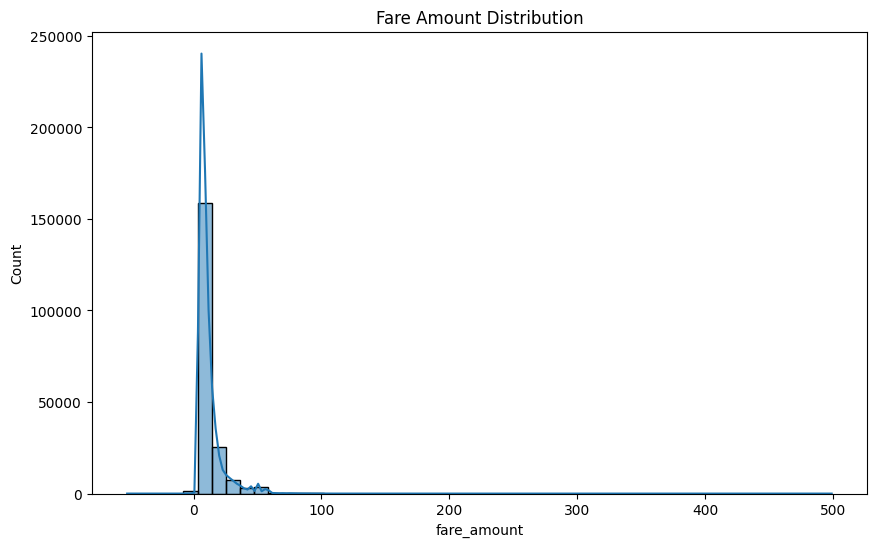

In [50]:
# Visualize fare distribution
plt.figure(figsize=(10, 6))
sns.histplot(uber_data['fare_amount'], bins=50, kde=True)
plt.title("Fare Amount Distribution")
plt.show()


**Observation**:
The distribution of ride distances shows an extremely skewed distribution with a large number of very short distances and a few very high distances (likely outliers).

**Interpretation**:
Most trips are short, with only a few longer rides.
The extremely high distances could indicate data quality issues, such as misreported coordinates or errors in GPS data.

**Action**: Data quality is crucial for predictive models, and these outliers can skew pricing models, especially for fare prediction and surge pricing. We should implement data validation processes to filter or correct erroneous data.

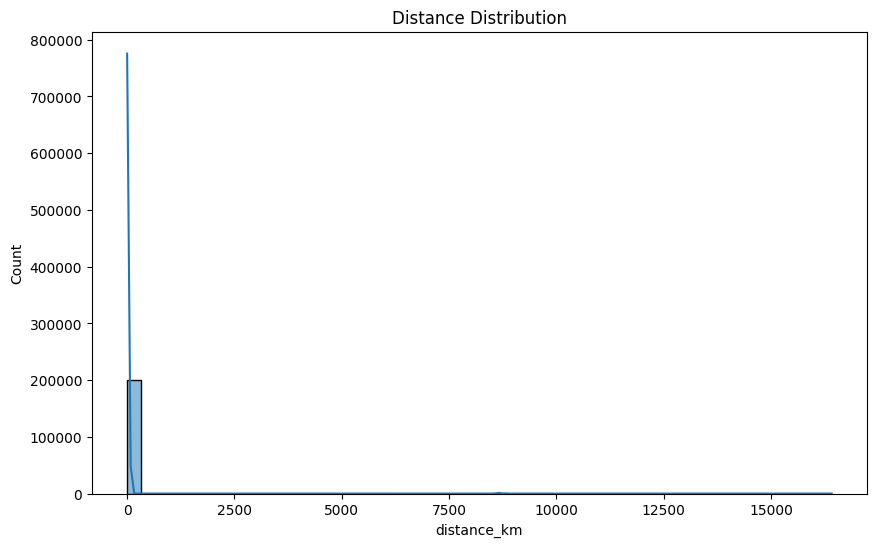

In [51]:

# Visualize distance distribution
plt.figure(figsize=(10, 6))
sns.histplot(uber_data['distance_km'], bins=50, kde=True)
plt.title("Distance Distribution")
plt.show()


### Correlation Matrix

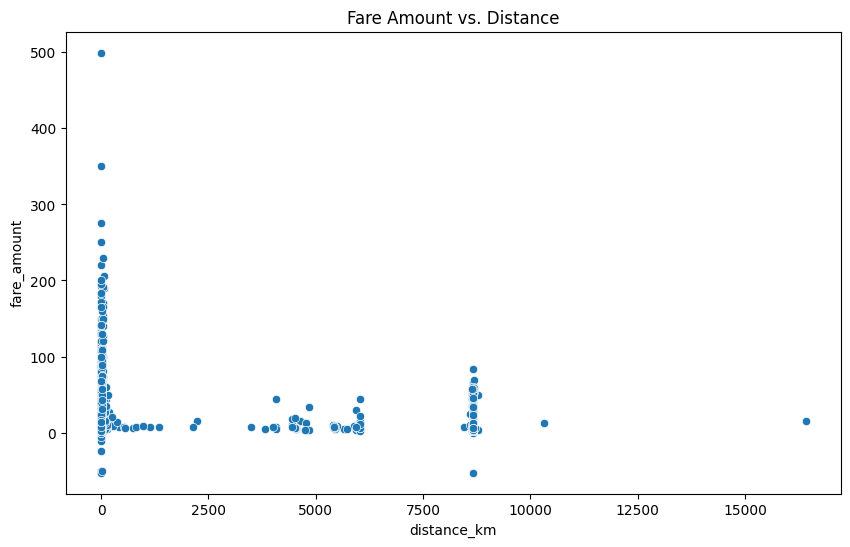

In [52]:

# Explore relationship between fare and distance
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance_km', y='fare_amount', data=uber_data)
plt.title("Fare Amount vs. Distance")
plt.show()


**Observation**:
Distance has a significant positive correlation with fare amount, meaning that the longer the trip, the higher the fare.
Coordinates (latitude/longitude) and time-based features have relatively lower direct correlations with fare.

**Interpretation**:
Distance is the most important feature for determining fare, while time and location are secondary factors. These time and location features will likely play a role in predicting surge pricing and demand.


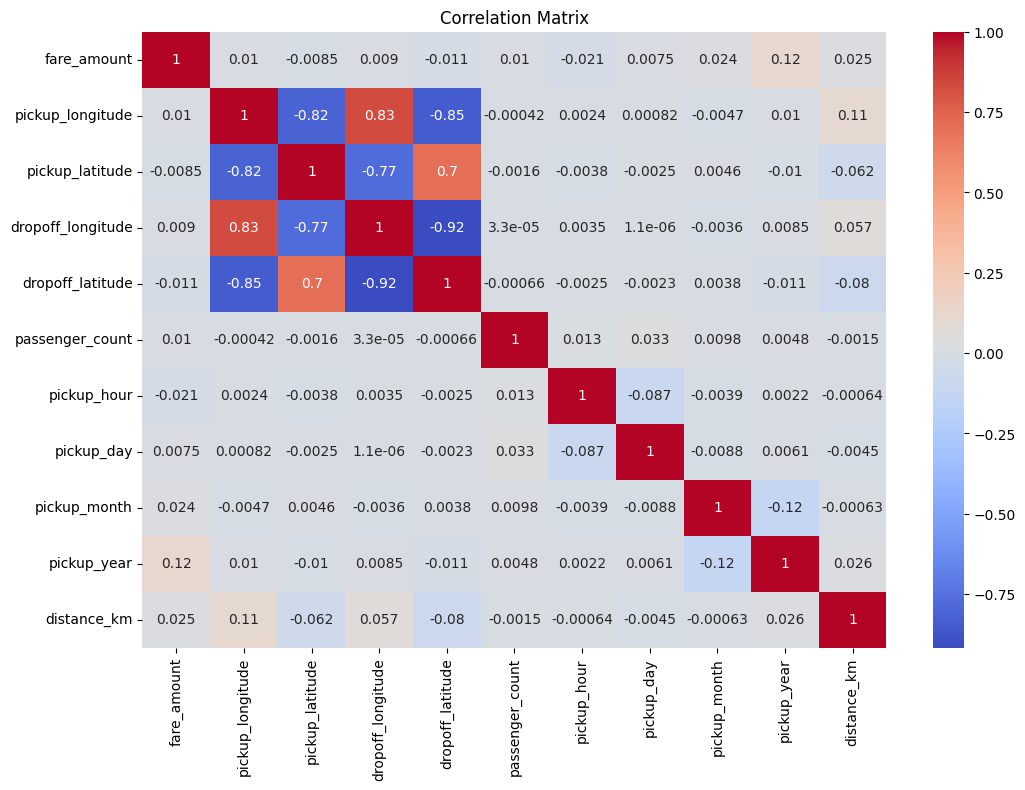

In [53]:

# Check correlations
corr_matrix = uber_data.select_dtypes(include=['number']).corr() # Select only numerical columns for correlation calculation
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


# Step 3: Building the Models


## 3.1 Feature Engineering

In [54]:
# Label high fares as surge pricing (1 if above threshold, 0 otherwise)
threshold = uber_data['fare_amount'].quantile(0.75)  # For example, using the 75th percentile as the surge threshold
uber_data['surge_pricing'] = (uber_data['fare_amount'] > threshold).astype(int)

# Select all features except target and datetime columns
features = ['pickup_hour', 'pickup_day', 'pickup_month', 'pickup_year',
            'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude',
            'passenger_count', 'distance_km']

X = uber_data[features]
y = uber_data['surge_pricing']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features (standardization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## 3.1. Dynamic Pricing (Surge Pricing) Prediction

Goal: Predict when surge pricing will occur based on features like demand, time, and location.



We’ll use a classification model like Random Forest to predict surge pricing based on the selected features.



In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Train a Random Forest Classifier with all features
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)


Model Evaluation : We will evaluate the model using accuracy, a confusion matrix, and a classification report.



Confusion Matrix:
 [[29142   916]
 [ 2162  7780]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95     30058
           1       0.89      0.78      0.83      9942

    accuracy                           0.92     40000
   macro avg       0.91      0.88      0.89     40000
weighted avg       0.92      0.92      0.92     40000

Accuracy Score: 0.92305


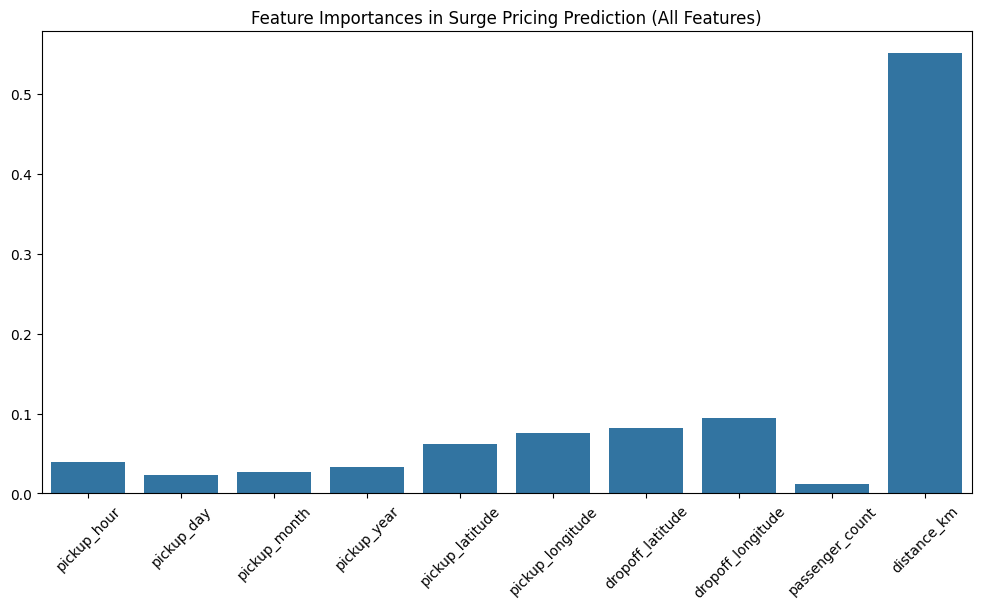

In [56]:
# Evaluate the model with all features
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Plot feature importance
feature_importances = rf_model.feature_importances_
plt.figure(figsize=(12, 6))
sns.barplot(x=features, y=feature_importances)
plt.title("Feature Importances in Surge Pricing Prediction (All Features)")
plt.xticks(rotation=45)
plt.show()


**Observation**:
Distance is overwhelmingly the most important feature for predicting surge pricing, followed by geographic features (pickup/dropoff latitude and longitude).

**Interpretation**:
Long trips are more likely to encounter surge pricing because they tend to consume more resources (driver time, fuel, etc.). Location also plays a significant role because certain areas may have higher demand/supply imbalances, leading to surge pricing.

##3.2: Demand Forecasting Model

Goal: Predict the number of ride requests in specific locations and time intervals.



### Time-Based Aggregation and Feature Engineering:

<ipython-input-69-297e80f3b561>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  uber_data['hourly'] = uber_data['pickup_datetime'].dt.floor('H')  # Round down to the nearest hour


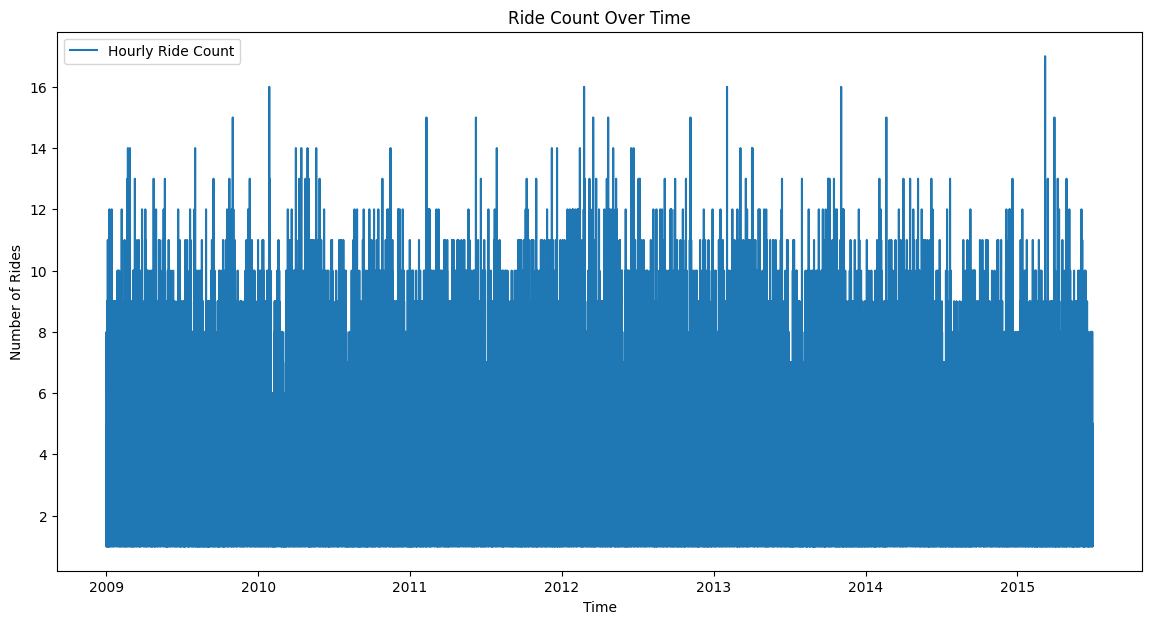

In [69]:
# Group the data by hour to count the number of rides in each hour
uber_data['hourly'] = uber_data['pickup_datetime'].dt.floor('H')  # Round down to the nearest hour

# Aggregate ride counts per hour
demand_data = uber_data.groupby('hourly').size().reset_index(name='ride_count')

# Create a datetime index for time series analysis
demand_data.set_index('hourly', inplace=True)

# Visualize the ride count over time
plt.figure(figsize=(14, 7))
plt.plot(demand_data.index, demand_data['ride_count'], label="Hourly Ride Count")
plt.title("Ride Count Over Time")
plt.xlabel("Time")
plt.ylabel("Number of Rides")
plt.legend()
plt.show()


**Observation**:
The ride count over time shows periodic fluctuations and some clear seasonal or cyclical patterns.

**Interpretation**:
This indicates that demand for rides follows time-based patterns, likely influenced by factors such as the day of the week, time of day, and possibly holidays or events.
There are peaks and troughs indicating high-demand periods (e.g., rush hours, weekends, or event times) and low-demand periods (e.g., late at night or early mornings on weekdays).

**Action**: Uber should alert drivers during predictable high-demand periods and fewer during low-demand periods. Additionally, surge pricing can be more heavily enforced during peak periods.


**Business Impact:** Properly managing driver allocation based on demand predictions can help Uber minimize idle time for drivers and reduce waiting time for riders, improving the customer experience and boosting driver satisfaction.

### Time Series Forecasting Using Prophet:

In [70]:
# Import Prophet (install if necessary)
!pip install prophet

                   ds  y
0 2009-01-01 01:00:00  2
1 2009-01-01 02:00:00  5
2 2009-01-01 03:00:00  1
3 2009-01-01 04:00:00  4
4 2009-01-01 05:00:00  1


DEBUG:cmdstanpy:input tempfile: /tmp/tmpr6uej724/3850_tvc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr6uej724/2xye1161.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23300', 'data', 'file=/tmp/tmpr6uej724/3850_tvc.json', 'init=/tmp/tmpr6uej724/2xye1161.json', 'output', 'file=/tmp/tmpr6uej724/prophet_modelr6cxqe5x/prophet_model-20241023163925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:39:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:39:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


<Figure size 1400x700 with 0 Axes>

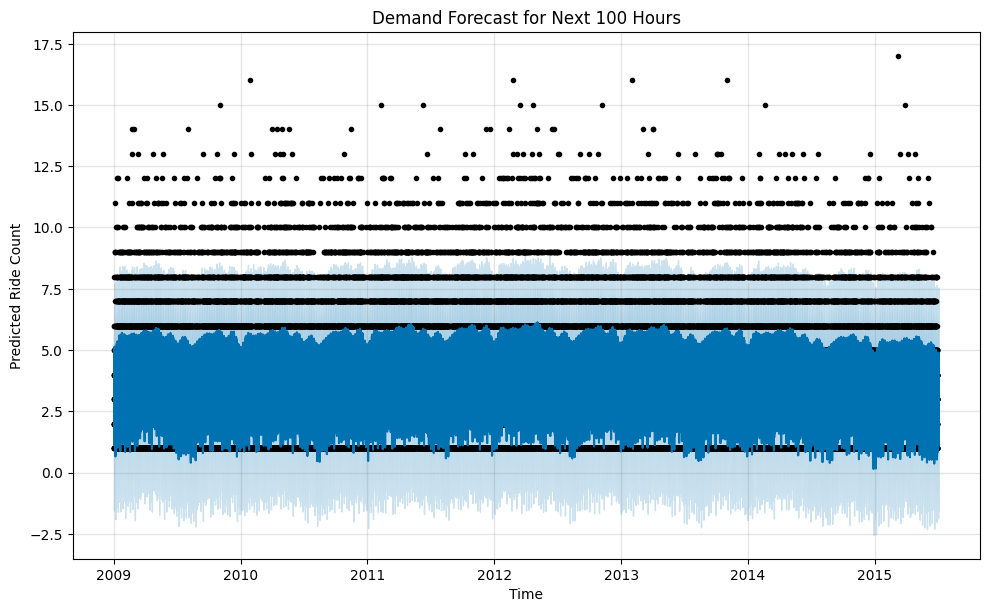

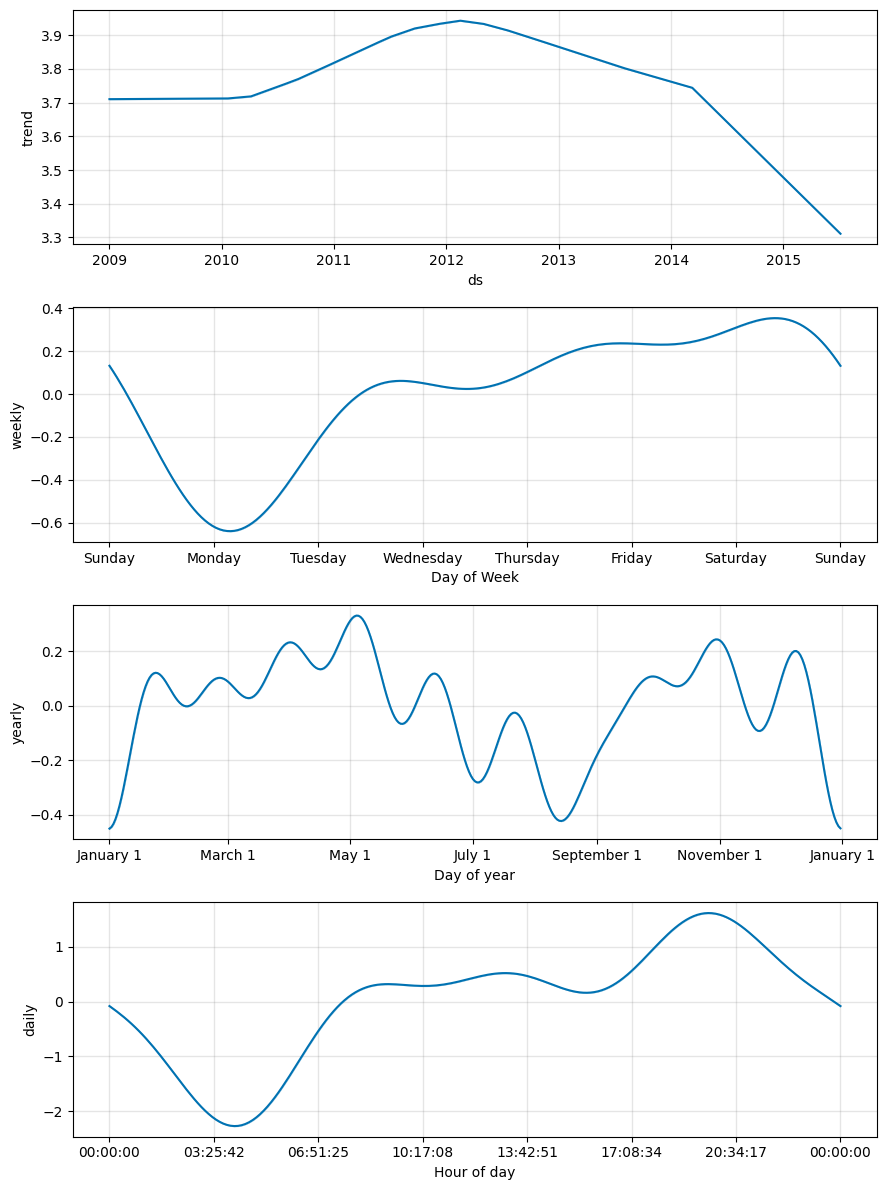

In [72]:

from prophet import Prophet

# Prepare data for Prophet by renaming columns to 'ds' and 'y'
df_prophet = demand_data.reset_index().rename(columns={'hourly': 'ds', 'ride_count': 'y'})

# Remove timezone information from the 'ds' column
df_prophet['ds'] = pd.to_datetime(df_prophet['ds']).dt.tz_localize(None)

# Check the first few rows to confirm column renaming
print(df_prophet.head())

# Initialize and train the model
prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=True)
prophet_model.fit(df_prophet)

# Create a dataframe for future predictions (next 100 hours as an example)
future = prophet_model.make_future_dataframe(periods=100, freq='H')
forecast = prophet_model.predict(future)

# Visualize the forecast
plt.figure(figsize=(14, 7))
prophet_model.plot(forecast)
plt.title("Demand Forecast for Next 100 Hours")
plt.xlabel("Time")
plt.ylabel("Predicted Ride Count")
plt.show()

# Plot forecast components (trend and seasonality)
prophet_model.plot_components(forecast)
plt.show()


### Model Evaluation

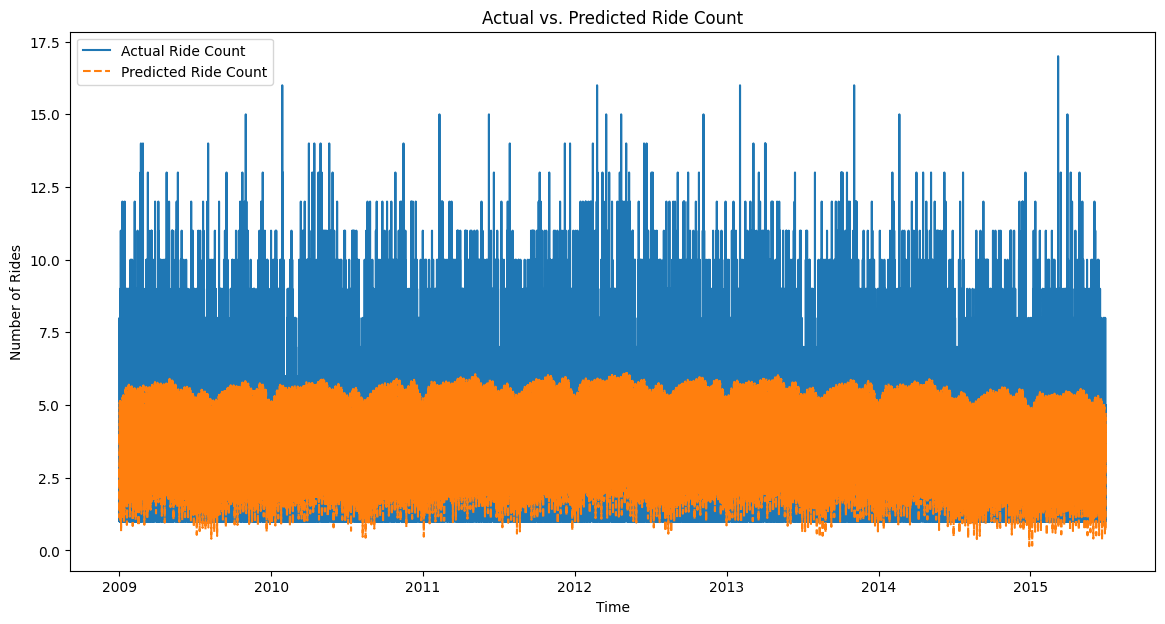

Mean Absolute Error (MAE): 1.6044060914787484


In [73]:
# Merge the actual data with the forecast
merged_data = df_prophet.set_index('ds').join(forecast[['ds', 'yhat']].set_index('ds'))

# Plot the actual vs. predicted ride count
plt.figure(figsize=(14, 7))
plt.plot(merged_data.index, merged_data['y'], label="Actual Ride Count")
plt.plot(merged_data.index, merged_data['yhat'], label="Predicted Ride Count", linestyle='--')
plt.title("Actual vs. Predicted Ride Count")
plt.xlabel("Time")
plt.ylabel("Number of Rides")
plt.legend()
plt.show()

# Calculate Mean Absolute Error (MAE)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(merged_data['y'], merged_data['yhat'])
print(f"Mean Absolute Error (MAE): {mae}")
